### Version wk of 2/22
- Mean encoding of single, double, triple variables
- Add weight to different point in random forest
- Geo-clustering of the train only
- For sensor data, group by street,dow and hour then get mean and ratio - then join to train
- Fixed f0.5 score
- Run Random Forest model (through grid search max_depth = 3, max_feature = 0.6)

### Things to include in next version:
- Geo-clustering of sensor and parking record data if possible
- Join with other tables based on Street or Geo-clustering
- PM district and area - join to train as a categorical variable

In [1]:
import pandas as pd
import numpy as np

In [24]:
# helper function
def display_all(df):
    with pd.option_context("display.max_rows", 1000): 
        with pd.option_context("display.max_columns", 1000): 
            display(df)

#### Import train and test files

In [3]:
train = pd.read_csv('../data/train-parking.csv', parse_dates=[[3,4]], infer_datetime_format=True)
test=pd.read_csv('../data/test-no-label-parking.csv', parse_dates=[[3,4]], infer_datetime_format=True)

#### Import geocoded street files & Join with train & test

In [4]:
st_latlng = pd.read_csv("../data/train_longlat.csv", index_col = False,  dtype = {'lat':np.float64,'lng':np.float64})
st_latlng.head()

,Street,From,To,lat,lng
0,Mission Street,25th Street,26th Street,37.750648,-122.418316
1,Polk Street,Ellis Street,Olive Street,37.784040,-122.419381
2,Van Ness Avenue,Geary Boulevard,Myrtle Street,37.785660,-122.421476
3,Van Ness Avenue,Bush Street,Fern Street,37.788499,-122.421892
4,Van Ness Avenue,Daniel Burnham Court,Post Street,37.787084,-122.421757


In [5]:
train = pd.merge(train,st_latlng,how ='left',left_on=["Street","From","To"], right_on=["Street","From","To"])
test= pd.merge(test,st_latlng,how ='left',left_on=["Street","From","To"], right_on=["Street","From","To"])

In [6]:
train.head()

,Date_Time,Street,From,To,Real.Spots,Street.Length,any_spot,lat,lng
0,2014-01-07 16:19:00,Mission Street,25th Street,26th Street,4,179.132970,1,37.750648,-122.418316
1,2014-01-18 20:42:00,Polk Street,Ellis Street,Olive Street,0,52.740210,0,37.784040,-122.419381
2,2014-01-18 20:39:00,Van Ness Avenue,Geary Boulevard,Myrtle Street,0,52.517840,0,37.785660,-122.421476
3,2014-01-18 20:38:00,Van Ness Avenue,Bush Street,Fern Street,0,52.405315,0,37.788499,-122.421892
4,2014-01-18 20:38:00,Van Ness Avenue,Daniel Burnham Court,Post Street,0,52.191193,0,37.787084,-122.421757


### Load in aggregated sensor data

In [7]:
sensor = pd.read_csv('../data/aggregated_sensor.csv')

In [8]:
sensor['TIME_OF_DAY'] = sensor['TIME_OF_DAY']/100
sensor['TIME_OF_DAY'] = sensor['TIME_OF_DAY'].astype('int')

In [9]:
sensor.head()

,STREET_NAME,DOW,TIME_OF_DAY,TOTAL_OCCUPIED_TIME_pct,TOTAL_VACANT_TIME_pct,TOTAL_UNKNOWN_TIME_pct,OP_OCCUPIED_TIME_pct,OP_VACANT_TIME_pct,OP_UNKNOWN_TIME_pct,NONOP_OCCUPIED_TIME_pct,...,GMP_VACANT_TIME_pct,GMP_UNKNOWN_TIME_pct,COMM_OCCUPIED_TIME_pct,COMM_VACANT_TIME_pct,COMM_UNKNOWN_TIME_pct,TOTAL_TIME_spots,OP_TIME_spots,NONOP_TIME_spots,GMP_TIME_spots,COMM_TIME_spots
0,01st street,0,0,0.354069,0.565198,0.080734,0.0,0.0,0.0,0.354069,...,0.0,0.0,0.0,0.0,0.0,35,0,35,0,0
1,01st street,0,1,0.342599,0.574450,0.082952,0.0,0.0,0.0,0.342599,...,0.0,0.0,0.0,0.0,0.0,35,0,35,0,0
2,01st street,0,2,0.334373,0.580756,0.084872,0.0,0.0,0.0,0.334373,...,0.0,0.0,0.0,0.0,0.0,35,0,35,0,0
3,01st street,0,3,0.330584,0.583502,0.085914,0.0,0.0,0.0,0.330584,...,0.0,0.0,0.0,0.0,0.0,35,0,35,0,0
4,01st street,0,4,0.335564,0.577616,0.086820,0.0,0.0,0.0,0.335564,...,0.0,0.0,0.0,0.0,0.0,35,0,35,0,0


## Geocode Clustering

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

spots = np.vstack(train[['lat','lng']].values)
kmeans = KMeans().fit(spots)
train['street_cluster'] = kmeans.predict(train[['lat', 'lng']])

In [11]:
test['street_cluster'] = kmeans.predict(test[['lat', 'lng']])

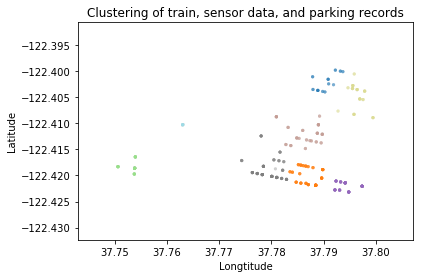

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.lat.values, train.lng.values, s=10, lw=0,
           c=train.street_cluster.values, cmap='tab20', alpha=0.2)
ax.set_xlabel('Longtitude')
ax.set_ylabel('Latitude')
plt.title('Clustering of train, sensor data, and parking records')
plt.show()

#### Get Time Features

In [13]:
train['Minute'] = train.Date_Time.dt.minute
test['Minute'] = test.Date_Time.dt.minute
train['Hour'] = train.Date_Time.dt.hour
test['Hour'] = test.Date_Time.dt.hour
train['Dow'] = train.Date_Time.dt.weekday
test['Dow'] = test.Date_Time.dt.weekday

In [14]:
# Convert the time (Hour, Minute) to a numerical value XXXX
train['Time'] = train["Hour"]*100 + train['Minute']
test['Time'] = test["Hour"]*100 + test['Minute']

In [15]:
def day_type(x):
    if x == 6 or x == 0:
        return 1
    else:
        return 0
    
train['isweekend'] = train['Dow'].apply(day_type)
test['isweekend'] = test['Dow'].apply(day_type)

#### Single Variable Mean Encoding

In [16]:
from sklearn.model_selection import KFold

def multi_reg_mean_encoding(train, cols, splits =5):
    kf = KFold(n_splits = splits)
    global_mean = train.any_spot.mean()
    
    for col in cols:
        means = train.groupby(col).any_spot.mean()
        train[col+'_mean_enc'] = train[col].map(means)        
        for tr_ind,val_ind in kf.split(train):
            tr,val = train.iloc[tr_ind],train.iloc[val_ind]
            foldmeans = tr.groupby(col).any_spot.mean()
            train.loc[val_ind,col+"_mean_enc"] = train.loc[val_ind,col].map(foldmeans)    
        train[col+"_mean_enc"].fillna(global_mean,inplace=True)   
        
#mean encoding for validation and test data
def multi_test_mean_encoding(test, train, cols):
    for col in cols:
        global_mean = train.any_spot.mean()
        means = train.groupby(col).any_spot.mean()
        test[col+"_mean_enc"] = test[col].map(means)
        test[col+"_mean_enc"].fillna(global_mean, inplace=True)

In [17]:
#create a column for From_To pair
train['From_To'] = train['From'] + '_' + train['To']
test['From_To'] = test['From'] + '_' + test['To']

In [18]:
train.columns

Index([u'Date_Time', u'Street', u'From', u'To', u'Real.Spots',
       u'Street.Length', u'any_spot', u'lat', u'lng', u'street_cluster',
       u'Minute', u'Hour', u'Dow', u'Time', u'isweekend', u'From_To'],
      dtype='object')

In [19]:
cols = ['Dow','isweekend','From_To','Street','Hour', 'street_cluster' ]
multi_reg_mean_encoding(train, cols, splits =5)
multi_test_mean_encoding(test, train, cols)

#### Double Variable Mean Encoding

In [20]:
colpairs = [('street_cluster','Dow'),('Dow','Hour'), ('street_cluster','Hour'),
            ('street_cluster','isweekend'),('From_To','Dow'),('From_To','Hour')]
pairlist = []
for pair in colpairs:
    colname = pair[0] + '_' + pair[1]
    pairlist.append(colname)
    train[colname] = list(zip(train[pair[0]], train[pair[1]]))
    test[colname] = list(zip(test[pair[0]], test[pair[1]]))

In [21]:
multi_reg_mean_encoding(train, pairlist, splits =5)
multi_test_mean_encoding(test, train, pairlist)

In [22]:
#drop Data_Time, Real.Spots, street_cluster_Dow, Dow_Hour, street_cluster_Hour, street_cluster_isweekend, From_To_Dow, From_To_Hour
train = train.drop(['Date_Time','Real.Spots', 'street_cluster_Dow', 'Dow_Hour', 'street_cluster_Hour', 'street_cluster_isweekend', 'From_To_Dow', 'From_To_Hour'], axis =1)
test = test.drop(['Date_Time', 'street_cluster_Dow', 'Dow_Hour', 'street_cluster_Hour', 'street_cluster_isweekend', 'From_To_Dow', 'From_To_Hour'], axis = 1)

In [27]:
train['Street'] = train.Street.str.lower()
train['From'] = train.From.str.lower()
train['To'] = train.To.str.lower()
test['Street'] = test.Street.str.lower()
test['From'] = test.From.str.lower()
test['To'] = test.To.str.lower()

In [29]:
train.head().T

,0,1,2,3,4
Street,mission street,polk street,van ness avenue,van ness avenue,van ness avenue
From,25th street,ellis street,geary boulevard,bush street,daniel burnham court
To,26th street,olive street,myrtle street,fern street,post street
Street.Length,179.133,52.7402,52.5178,52.4053,52.1912
any_spot,1,0,0,0,0
lat,37.7506,37.784,37.7857,37.7885,37.7871
lng,-122.418,-122.419,-122.421,-122.422,-122.422
street_cluster,2,1,1,1,1
Minute,19,42,39,38,38
Hour,16,20,20,20,20


In [36]:
mtrain = pd.merge(train,sensor, how='left',left_on=['Street','Dow','Hour'], right_on=['STREET_NAME','DOW','TIME_OF_DAY'])
mtest = pd.merge(test,sensor, how='left',left_on=['Street','Dow','Hour'], right_on=['STREET_NAME','DOW','TIME_OF_DAY'])

In [56]:
mtrain = mtrain.drop(['STREET_NAME','DOW','TIME_OF_DAY'],axis =1)
mtest = mtest.drop(['STREET_NAME','DOW','TIME_OF_DAY'],axis =1)

#### Convert categorical variables to codes

In [57]:
def process_dfs(train_df, test_df, cols):
    # transfer categorical 
    for name in cols:
        train_df[name]=train_df[name].astype('category').cat.as_ordered()
        test_df[name] = pd.Categorical(test_df[name], categories=train_df[name].cat.categories, ordered=True)
    return train_df, test_df
  
def cat2code(train_df, test_df, cols):
    # transfer categorical 
    for name in cols:
        train_df[name]= train_df[name].cat.codes
        test_df[name] = test_df[name].cat.codes
    return train_df, test_df

In [58]:
catcols = ['Street','From','To', 'From_To']
newtrain,newtest = process_dfs(mtrain.copy(),mtest.copy(),catcols)
newtrain,newtest = cat2code(newtrain,newtest,catcols)

#### Split response and dependent variable

In [59]:
def split_response(df, response):
    y = df[response].values
    df.drop([response],axis=1,inplace=True)
    return df,y

X_train,y_train = split_response(newtrain.copy(),'any_spot')

In [60]:
X_train.dtypes

Street                                  int8
From                                    int8
To                                      int8
Street.Length                        float64
lat                                  float64
lng                                  float64
street_cluster                         int32
Minute                                 int64
Hour                                   int64
Dow                                    int64
Time                                   int64
isweekend                              int64
From_To                                 int8
Dow_mean_enc                         float64
isweekend_mean_enc                   float64
From_To_mean_enc                     float64
Street_mean_enc                      float64
Hour_mean_enc                        float64
street_cluster_mean_enc              float64
street_cluster_Dow_mean_enc          float64
Dow_Hour_mean_enc                    float64
street_cluster_Hour_mean_enc         float64
street_clu

#### F0.5 score calculator - soft predictions

In [47]:
def f05_score_soft(preds, labels):
    tp = np.sum((labels==(preds>0.5)) & (labels==1))
    tn = np.sum((labels==(preds<0.5)) & (labels==0))
    fp = np.sum((preds>0.5))-tp
    fn = np.sum(preds<0.5)-tn
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    score = 1.25*p*r/(0.25*p+r)
    return score

#### F0.5 score calculator - hard predictions

In [76]:
def f05_score_hard(preds, labels):
    tp = np.sum((labels==preds) & (labels==1))
    tn = np.sum((labels==preds) & (labels==0))
    fp = np.sum(preds==1)-tp
    fn = np.sum(preds==0)-tn
#    print(tp, tn, fp, fn)
    p = tp*1.0/(tp+fp)
    r = tp*1.0/(tp+fn)
    score = 1.25*p*r/(0.25*p+r)
    return score

In [61]:
newtrain.columns

Index([u'Street', u'From', u'To', u'Street.Length', u'any_spot', u'lat',
       u'lng', u'street_cluster', u'Minute', u'Hour', u'Dow', u'Time',
       u'isweekend', u'From_To', u'Dow_mean_enc', u'isweekend_mean_enc',
       u'From_To_mean_enc', u'Street_mean_enc', u'Hour_mean_enc',
       u'street_cluster_mean_enc', u'street_cluster_Dow_mean_enc',
       u'Dow_Hour_mean_enc', u'street_cluster_Hour_mean_enc',
       u'street_cluster_isweekend_mean_enc', u'From_To_Dow_mean_enc',
       u'From_To_Hour_mean_enc', u'TOTAL_OCCUPIED_TIME_pct',
       u'TOTAL_VACANT_TIME_pct', u'TOTAL_UNKNOWN_TIME_pct',
       u'OP_OCCUPIED_TIME_pct', u'OP_VACANT_TIME_pct', u'OP_UNKNOWN_TIME_pct',
       u'NONOP_OCCUPIED_TIME_pct', u'NONOP_VACANT_TIME_pct',
       u'NONOP_UNKNOWN_TIME_pct', u'GMP_OCCUPIED_TIME_pct',
       u'GMP_VACANT_TIME_pct', u'GMP_UNKNOWN_TIME_pct',
       u'COMM_OCCUPIED_TIME_pct', u'COMM_VACANT_TIME_pct',
       u'COMM_UNKNOWN_TIME_pct', u'TOTAL_TIME_spots', u'OP_TIME_spots',
       u'N

#### Grid search for best max_features & max_depth

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {"max_features": [0.2,0.4,0.5,0.6,0.8,0.9,1],
              "max_depth": [3,5,10,15,20,25,30],
             'n_estimators': [10, 20, 30, 40, 50]}

rf = RandomForestClassifier(min_samples_split=2, n_jobs=-1)
gs_rf = GridSearchCV(cv=5, param_grid=param_grid, estimator=rf,scoring='neg_log_loss')
gs_rf.fit(X_train,y_train)
print (gs_rf.best_params_);print (gs_rf.best_score_)

{'max_features': 0.6, 'n_estimators': 50, 'max_depth': 3}
-0.630704156267


/Users/Grace/anaconda/envs/fastai/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


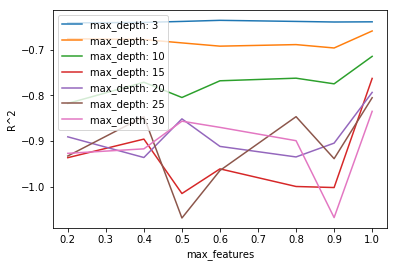

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline
max_features = param_grid['max_features']
max_depth = param_grid['max_depth']
scores = [x[1] for x in gs_rf.grid_scores_]
scores = np.array(scores).reshape(len(max_features),len(max_depth))
for ind, i in enumerate(max_depth):
    plt.plot(max_features, scores[ind],label = 'max_depth: '+ str(i))
plt.legend()
plt.xlabel('max_features')
plt.ylabel('R^2')
plt.show()

#### Feature importance

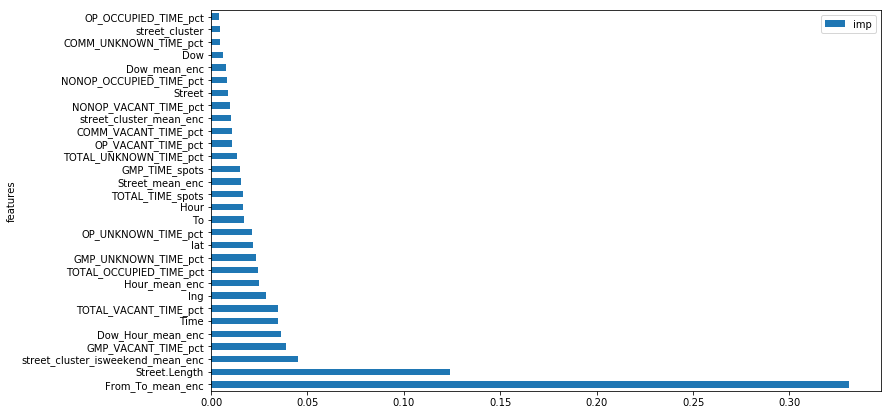

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)
m2 = RandomForestClassifier(n_estimators = 50, min_samples_split = 2, max_features= 0.6, max_depth =3, n_jobs=-1)
m2.fit(X_train,y_train)

#plot feature importance
feat_imp = pd.DataFrame({
    'features': X_train.columns,
    'imp' :m2.feature_importances_
})
feat_imp.sort_values(by='imp', inplace=True, ascending=False)
feat_imp[:30].plot('features','imp','barh', figsize=(12,7))

In [65]:
feat_imp.sort_values("imp")

,features,imp
44,COMM_TIME_spots,0.000000
11,isweekend,0.000000
12,From_To,0.001135
7,Minute,0.001322
34,GMP_OCCUPIED_TIME_pct,0.001374
21,street_cluster_Hour_mean_enc,0.001430
1,From,0.001481
37,COMM_OCCUPIED_TIME_pct,0.002014
42,NONOP_TIME_spots,0.002126
33,NONOP_UNKNOWN_TIME_pct,0.002423


In [66]:
to_keep = feat_imp[feat_imp['imp'] > 0.005].features
x_bestfeat = X_train[to_keep]
x_bestfeat_t = newtest[to_keep]

### Calculate F0.5 score and make prediction

In [89]:
np.random.seed(0)
mf = RandomForestClassifier(n_estimators = 50, min_samples_split = 2, max_features= 0.6, max_depth =3, n_jobs=-1)
mf.fit(x_bestfeat,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=0.6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [90]:
trainpreds = mf.predict(x_bestfeat)
f05_score_hard(y_train,trainpreds)

0.56272586473928754

In [91]:
testpreds = mf.predict(x_bestfeat_t)
result = pd.DataFrame({"id": np.arange(1,len(newtest)+1),"any_spot":testpreds})
result = result[['id','any_spot']].to_csv("../223_nowg0", index =False)

### ADD Weight to 1s

In [79]:
mfw = RandomForestClassifier(n_estimators = 50, min_samples_split = 2, max_features= 0.6, 
                             max_depth =3, n_jobs=-1,class_weight ={0:1,1:0.85})
mfw.fit(x_bestfeat,y_train)

trainpreds = mfw.predict(x_bestfeat)


tn, fp, fn, tp = confusion_matrix(y_train, trainpreds).ravel()
print (tn, fp, fn, tp)

(628, 71, 218, 183)


In [84]:
f05_score_hard(y_train,trainpreds)

0.49246501614639393

In [85]:
testpreds = mfw.predict(x_bestfeat_t)
result = pd.DataFrame({"id": np.arange(1,len(newtest)+1),"any_spot":testpreds})
result[['id','any_spot']].to_csv("../223_wwg", index =False)